In [1]:
import numpy as np
from astropy.io import fits
import Functions
import matplotlib.pyplot as plt
import skimage.io
import skimage.filters
import pymaster as nmt

In [28]:
hudl = fits.open('ICM_old/data/map2048_MILCA_Coma_20deg_G.fits')
data = hudl[1].data

pixsize = 1.7177432059
arcmin2kpc = 27.052

norm_y_fluc = np.loadtxt('ICM_old/data/normalised_y_fluc.txt')
norm_y_fluc_gaussianblur = np.loadtxt('normalised_y_fluc_gaussianblur.txt')



Lx = 4. * np.pi/180
Ly = 4. * np.pi/180
Nx, Ny = len(norm_y_fluc),  len(norm_y_fluc)

In [8]:
"------------------------------- CREATING MASKS -------------------------------"

mask = np.zeros((Nx,Ny))
#the centre will always be the middle elements becuase of the way the fluctuation maps have been computed
cen_x, cen_y = Nx/2., Ny/2.
cr = 60 #radius of mask in arcmin
I,J=np.meshgrid(np.arange(mask.shape[0]),np.arange(mask.shape[1]))
dist=np.sqrt((I-cen_x)**2+(J-cen_y)**2)
dist = dist * pixsize
idx = np.where(dist<=cr)
theta_ap = 15 #apodization scale in arcmin
mask[idx]=1-np.exp(-9*(dist[idx]-cr)**2/(2*theta_ap**2)) #described in Khatri et al.

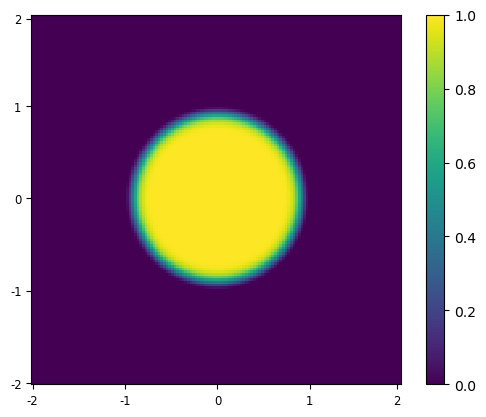

In [10]:
"---------------------------- PLOTTING APODIZED MASK --------------------------"

plt.figure()
x_ticks = ['-2', '-1','0','1','2']
y_ticks = ['-2', '-1','0','1','2']
t11 = [0,35,70,105,138]
plt.xticks(ticks=t11, labels=x_ticks, size='small')
plt.yticks(ticks=t11, labels=y_ticks, size='small')
plt.imshow(mask, interpolation='nearest', origin='lower')
plt.colorbar()
plt.show()

In [12]:
"------------------------------ CREATING BINS ---------------------------------"

bin_number = 6
#l's have to be converted from kpc using l = pi/angular sep
# We want to use bin sizes between 500 and 2000 kpc in terms of l's
l_min =  (180*60*arcmin2kpc/2000)
l_max = (180*60*arcmin2kpc/500)

bin_size = (l_max-l_min)/bin_number

l0_bins=[]
lf_bins=[]

for i in range (bin_number):
    l0_bins.append(l_min+bin_size*i)
    lf_bins.append(l_min+bin_size*(i+1))

print("\n************************  effective l's  *****************************\n")

b = nmt.NmtBinFlat(l0_bins, lf_bins)
ells_uncoupled = b.get_effective_ells()
print(ells_uncoupled)

lambdas_inv = ells_uncoupled/(arcmin2kpc*60*180)
k = 2*np.pi*lambdas_inv



************************  effective l's  *****************************

[182.601  255.6414 328.6818 401.7222 474.7626 547.803 ]


In [13]:
"----------------------------- DEFINING BEAM ------------------------------------"
#refer to beam_test.py
"""params:
    -> l: array-like; ell values 
   returns:
    -> array-like; value of beam at those ells
"""

def beam(l):
    Planck_res=10./60 
    Planck_sig = Planck_res/2.3548
    return np.exp(-0.5*l*(l+1)*(Planck_sig*np.pi/180)**2)

(140, 140)
(700, 700)


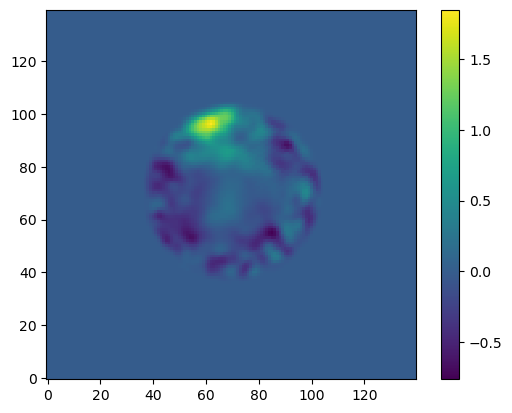

In [41]:
"----------------------------- PLOTTING FIELD WITH MASK -------------------------"
print(np.shape(norm_y_fluc))
print(np.shape(data))
f0 = nmt.NmtFieldFlat(Lx, Ly, mask, [norm_y_fluc] ,beam=[ells_uncoupled, beam(ells_uncoupled)])

plt.figure()
#plt.imshow(f0.get_maps()[0],vmin=-1.5, vmax=1.5)
plt.imshow(f0.get_maps()[0], interpolation='nearest', origin='lower')
plt.colorbar()
plt.show()

In [32]:
print("\n--------------------------- ANGULAR POWER SPECTRUM ------------------------------------\n")

w00 = nmt.NmtWorkspaceFlat()
w00.compute_coupling_matrix(f0, f0, b)
#Coupling matrix used to estimate angular spectrum
cl00_coupled = nmt.compute_coupled_cell_flat(f0, f0, b)
cl00_uncoupled = w00.decouple_cell(cl00_coupled)[0]
print(cl00_uncoupled)

amp = abs((ells_uncoupled**2)*cl00_uncoupled/(2*np.pi))**(1/2)

print("\n*************************  Covariance matrix  *************************************\n")

cw = nmt.NmtCovarianceWorkspaceFlat()
cw.compute_coupling_coefficients(f0, f0, b)
covar = nmt.gaussian_covariance_flat(cw, 0, 0, 0, 0, ells_uncoupled,
                                     [cl00_uncoupled], [cl00_uncoupled],
                                     [cl00_uncoupled], [cl00_uncoupled], w00)

print(covar)
std_power = (np.diag(covar))
std_amp = np.sqrt(abs((ells_uncoupled**2)*std_power/(2*np.pi))**(1/2))


--------------------------- ANGULAR POWER SPECTRUM ------------------------------------

[7.74099867e-08 3.78396352e-07 3.46837280e-07 2.93213263e-07
 1.21319913e-07 3.06625252e-07]

*************************  Covariance matrix  *************************************

[[ 8.38638845e-13 -1.57546358e-12  9.56926731e-13  3.77523811e-13
  -4.33381687e-13  5.25851107e-13]
 [-1.57546358e-12  3.10613922e-12 -2.37130031e-12 -5.23284202e-13
   8.18156182e-13 -1.00321650e-12]
 [ 9.56926731e-13 -2.37130031e-12  4.00665513e-12 -9.55348692e-13
  -1.84493987e-13  2.49258543e-13]
 [ 3.77523811e-13 -5.23284202e-13 -9.55348692e-13  1.70892796e-12
  -9.92174766e-13  1.30811902e-12]
 [-4.33381687e-13  8.18156182e-13 -1.84493987e-13 -9.92174766e-13
   8.89857378e-13 -1.40263817e-12]
 [ 5.25851107e-13 -1.00321650e-12  2.49258543e-13  1.30811902e-12
  -1.40263817e-12  2.59958855e-12]]


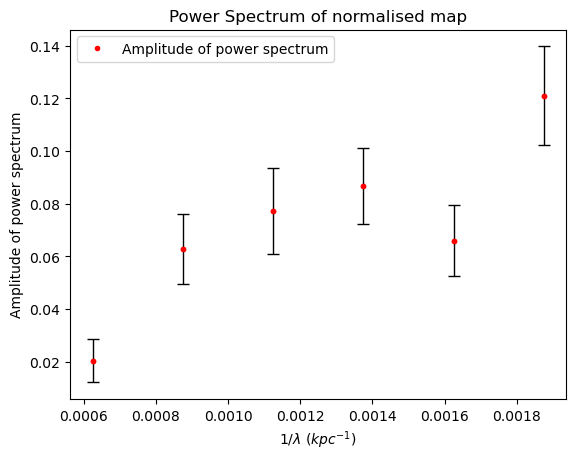

In [36]:
plt.figure()
plt.plot(lambdas_inv, amp, 'r.', label='Amplitude of power spectrum')
plt.errorbar(lambdas_inv,amp, yerr=std_amp, fmt='r.',ecolor='black',elinewidth=1,
            capsize = 4)
#plt.plot(lambdas_inv_curve, curve, 'b', 
#          label='Best fit: Power law (power = %1.2f)'%p_fit)
plt.xlabel("$1/\lambda$ ($kpc^{-1}$)")
plt.ylabel("Amplitude of power spectrum")
plt.legend()
plt.title("Power Spectrum of normalised map")
plt.show()


----------------- PRESSURE POWER SPECTRUM ---------------------------------



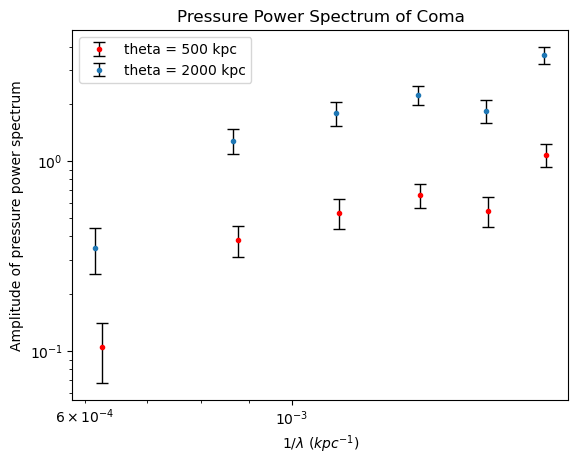

In [34]:
print("\n----------------- PRESSURE POWER SPECTRUM ---------------------------------\n")

Ns = np.loadtxt("ICM_old/data/Ns.txt")
#Ns = 7e-4*np.ones_like(Ns)
amp_pressure = np.zeros((1500,6))

for i in range(500,2000):
    amp_pressure[i-500,:] = abs((ells_uncoupled**2)*cl00_uncoupled*k/(2*np.pi**2*Ns[i]))**(1/2)


plt.figure()
plt.errorbar(lambdas_inv,amp_pressure[0], yerr=std_amp*(k/Ns[0]/np.pi)**(1/2), fmt='r.',ecolor='black',elinewidth=1,
            capsize = 4,label="theta = 500 kpc")
# plt.errorbar(lambdas_inv+1e-5,amp_pressure[500], yerr=std_amp*(k/Ns[500]/np.pi)**(1/2), fmt='b.',ecolor='black',elinewidth=1,
#             capsize = 4,label="theta = 1000 kpc")
# plt.errorbar(lambdas_inv+2e-5,amp_pressure[1000], yerr=std_amp*(k/Ns[1000]/np.pi)**(1/2), fmt='g.',ecolor='black',elinewidth=1,
#             capsize = 4, label='theta = 1500 kpc')
plt.errorbar(lambdas_inv-1e-5,amp_pressure[1499], yerr=std_amp*(k/Ns[1499]/np.pi)**(1/2), fmt='.',ecolor='black',elinewidth=1,
            capsize = 4, label='theta = 2000 kpc')
plt.xlabel("$1/\lambda$ ($kpc^{-1}$)")
plt.ylabel("Amplitude of pressure power spectrum")
plt.legend()
plt.title("Pressure Power Spectrum of Coma")
plt.loglog()
plt.show()